### **Objectif**

Après avoir estimé la hauteur optimale de la digue à partir des données historiques, cette seconde approche repose sur un modèle hydraulique intégrant les lois physiques de l’écoulement et les incertitudes environnementales. L’objectif est de déterminer $h_d$ en minimisant la probabilité de surverse 
$P(S>0)$, c’est-à-dire la probabilité que l’eau dépasse la digue : $$P(S>0)=P(H>h_d+Z_b−Z_v)$$

où :
H est calculé à partir du débit de crue Q selon l’équation :
$$H = \left(\frac{Q}{K_s \sqrt{\frac{Z_m - Z_v}{L}} B}\right)^{\frac{3}{5}}$$
 
où :
- Q est le débit maximal annuel (m³/s), qui varie selon les crues.
- $𝐾_𝑠$ est un coefficient de frottement lié aux caractéristiques du terrain.
- $𝑍_𝑚$ et $Z_v$ sont respectivement les cotes amont et aval.
- L est la longueur du tronçon de rivière étudié.
- B est la largeur du lit du fleuve.

L’objectif est donc de choisir une hauteur optimale $h_d$ de manière à minimiser $P(S>0)$, tout en tenant compte des incertitudes affectant les variables du modèle.



### **Prise en Compte des Incertitudes**

Dans un environnement naturel, les paramètres du modèle ne sont pas parfaitement connus et varient au cours du temps. Plusieurs sources d’incertitude influencent directement la hauteur d’eau et la probabilité de surverse.

D’une part, la variabilité naturelle du débit $Q$, du coefficient de frottement $K_s$ et des cotes du lit du fleuve ($Z_m$ et $Z_v$) est liée aux fluctuations climatiques, météorologiques et hydrologiques. Le débit d’un fleuve est influencé par des événements extrêmes, tels que les fortes précipitations ou la fonte des neiges, ce qui rend ses valeurs imprévisibles d’une année à l’autre. De même, l’état du lit du fleuve évolue en raison de l’érosion et du dépôt de sédiments, modifiant ainsi les conditions d’écoulement.

D’autre part, il existe des incertitudes de mesure et de modélisation.

Afin d’intégrer ces incertitudes dans notre analyse, nous modélisons chaque variable aléatoire selon une distribution de probabilité :

| **Variable** | **Type de Loi** | **Paramètre 1** | **Paramètre 2** |
|-------------|----------------|-----------------|-----------------|
| **Débit \( Q \) (m³/s)** | Gumbel | 1013 (mode) | 558 (échelle) |
| **Coefficient de frottement \( K_s \)** | Normale | 30 (espérance) | 7.5 (écart-type) |
| **Cote aval \( Z_v \) (m NGF)** | Triangulaire | 50 (espérance) | 1 (demi-étendue) |
| **Cote amont \( Z_m \) (m NGF)** | Triangulaire | 55 (espérance) | 1 (demi-étend


Les autres paramètres du modèle sont considérés comme déterministes, notamment la longueur du tronçon (L=5000 m), la largeur du fleuve (B=300 m) et la cote de la berge ($Z_b$=55.5 m).e) |


### **Estimation de $P(S>0)$ par Simulation Monte-Carlo**

Le modèle hydraulique implique des relations non linéaires entre les variables d’entrée et la surcharge S. En raison de cette complexité, il est difficile d’obtenir une formule analytique exacte pour estimer la probabilité $P(S>0)$. Pour cette raison, nous utilisons une simulation Monte-Carlo, qui consiste à générer un grand nombre de scénarios aléatoires en échantillonnant Q, $K_s, Z_v , Z_m$ selon leurs distributions respectives, puis à calculer S pour chaque réalisation.

Cette méthode présente plusieurs avantages :

- Elle ne nécessite pas d’hypothèse restrictive sur la forme de la distribution de S, contrairement aux méthodes analytiques.
- Elle gère la complexité du modèle et sa non-linéarité.
- Elle capture directement les incertitudes en respectant les distributions de chaque paramètre.
- Elle permet d’optimiser la hauteur $h_d$ en testant plusieurs valeurs et en observant leur impact sur la probabilité de surverse.
 

In [1]:
import pandas as pd

# Charger le fichier CSV
df =  pd.ExcelFile("Données-Projet-Pratique-Fiabilité.xlsx")
print(df.sheet_names)  
df = df.parse(df.sheet_names[0])  # Charge la première feuille 

print("\nRésumé des valeurs manquantes :")
print(df.isnull().sum())
print(df["Hauteur associée mesurée (en m)"].describe())

['Données débit-hauteur', 'Données coûts']

Résumé des valeurs manquantes :
Année                                     0
Débit mesuré maximal annuel (en m3/s)     0
Hauteur associée mesurée (en m)          26
dtype: int64
count    123.000000
mean       3.896748
std        1.272337
min        1.000000
25%        3.100000
50%        3.900000
75%        4.750000
max        7.200000
Name: Hauteur associée mesurée (en m), dtype: float64


In [2]:
df

,Année,Débit mesuré maximal annuel (en m3/s),Hauteur associée mesurée (en m)
0,1849,3853.892756,NaN
1,1850,1256.402143,4.0
2,1851,1648.542191,4.5
3,1852,1604.857094,4.3
4,1853,341.157419,1.7
...,...,...,...
144,1993,740.178695,3.1
145,1994,3044.380648,7.2
146,1995,1127.889906,3.5
147,1996,522.151370,2.5


Nous avons pris n=10000 simulations pour l'Approche 2 car l'estimation de $h_d$ repose sur un quantile, et selon la règle 
$n=10^(k+2)$ avec k=2 pour un quantile, cela garantit une incertitude d'environ 10%, assurant ainsi une précision suffisante tout en restant raisonnable en termes de coût computationnel.

In [10]:
import numpy as np
from scipy.stats import gumbel_r, norm, triang

# 🔹 Paramètres fixes
L, B, Z_b = 5000, 300, 55.5  

# 🔹 Lois de probabilité des variables aléatoires
n_simulations = 10000

Q_sim = gumbel_r.rvs(loc=1013, scale=558, size=n_simulations)
Ks_sim = norm.rvs(loc=30, scale=7.5, size=n_simulations)
Zm_sim = triang.rvs(c=0.5, loc=54, scale=2, size=n_simulations)
Zv_sim = triang.rvs(c=0.5, loc=49, scale=2, size=n_simulations)

# 🔹 Calcul des hauteurs d’eau H
H_sim = (Q_sim / (Ks_sim * np.sqrt(((Zm_sim - Zv_sim)/L))*B)) ** (3/5)

# 🔹 Optimisation de h_d
h_d_values = np.arange(1, 9, 0.1)
P_surverse_values = [np.mean(H_sim - h_d - (Z_b - Zv_sim) > 0) for h_d in h_d_values]

# 🔹 Sélection de la hauteur optimale
h_d_optimal = h_d_values[np.argmin(np.abs(np.array(P_surverse_values)))]
print(f"Hauteur optimale de la digue : {h_d_optimal:.2f} m")


Hauteur optimale de la digue : 7.60 m


C:\Users\ouaha\AppData\Local\Temp\ipykernel_892\1986855653.py:16: RuntimeWarning: invalid value encountered in power
  H_sim = (Q_sim / (Ks_sim * np.sqrt(((Zm_sim - Zv_sim)/L))*B)) ** (3/5)


Une fois la simulation effectuée, nous regardons la distribution probabiliste de la simulation des hauteurs de crues.

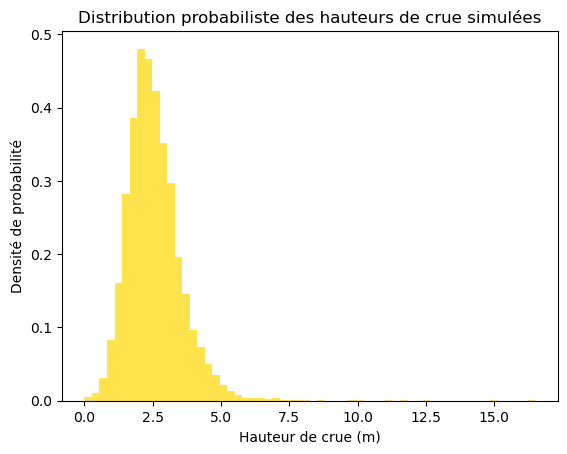

In [11]:
import matplotlib.pyplot as plt

# Supposons que H_sim contienne les hauteurs de crue simulées
plt.hist(H_sim, bins=60, density=True, alpha=0.7, color='gold')
plt.xlabel("Hauteur de crue (m)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution probabiliste des hauteurs de crue simulées")
plt.show()


La distribution obtenue après simulation Monte-Carlo montre une concentration des hauteurs de crue autour de valeurs comprises entre 2 m et 5 m, avec une faible probabilité d’atteindre des hauteurs extrêmes supérieures à 7 m.

In [14]:
n_simulations = 10000  # Nombre d'échantillons Monte Carlo
n_bootstrap = 1000  

h_d_bootstrap = []

for _ in range(n_bootstrap):
    # Recalculer H_sim avec un échantillonnage aléatoire (bootstrap)
    Q_resample = np.random.choice(Q_sim, size=n_simulations, replace=True)
    Ks_resample = np.random.choice(Ks_sim, size=n_simulations, replace=True)
    Zm_resample = np.random.choice(Zm_sim, size=n_simulations, replace=True)
    Zv_resample = np.random.choice(Zv_sim, size=n_simulations, replace=True)
    
    H_resample = (Q_resample / (Ks_resample * np.sqrt(((Zm_resample - Zv_resample)/L))*B)) ** (3/5)
    
    P_surverse_resample = [np.mean(H_resample - h_d - (Z_b - Zv_resample) > 0) for h_d in h_d_values]
    h_d_bootstrap.append(h_d_values[np.argmin(np.abs(np.array(P_surverse_resample)))])

# 🔹 Calcul des IC à 95%
z_alpha = norm.ppf(0.975)  # 1.96 pour IC à 95%
sigma_h_d = np.std(h_d_bootstrap)
IC_h_d_lower = h_d_optimal - z_alpha * sigma_h_d / np.sqrt(n_bootstrap)
IC_h_d_upper = h_d_optimal + z_alpha * sigma_h_d / np.sqrt(n_bootstrap)

# 🔹 Affichage des résultats
print(f"Hauteur optimale de la digue : {h_d_optimal:.2f} m")
print(f"IC à 95% pour h_d optimal : [{IC_h_d_lower:.2f} m ; {IC_h_d_upper:.2f} m]")


C:\Users\ouaha\AppData\Local\Temp\ipykernel_892\415235491.py:13: RuntimeWarning: invalid value encountered in power
  H_resample = (Q_resample / (Ks_resample * np.sqrt(((Zm_resample - Zv_resample)/L))*B)) ** (3/5)


Hauteur optimale de la digue : 7.60 m
IC à 95% pour h_d optimal : [7.52 m ; 7.68 m]


L’IC est relativement étroit, ce qui indique une bonne précision de l’estimation.

95% des estimations de Monte Carlo tomberaient dans cet intervalle.

La hauteur optimale estimée de 7.60 m assure une protection efficace contre la surverse.

Conclusion

L’approche Monte Carlo permet d’estimer de manière robuste  en tenant compte des incertitudes des variables hydrauliques. L’ajout d’un intervalle de confiance renforce la rigueur de l’analyse et aide à la prise de décision en fournissant une estimation fiable et quantifiée de l’incertitude.

Les deux approches adoptées dans cette étude aboutissent à des estimations relativement proches de la hauteur optimale de la digue, mais elles diffèrent dans leur méthodologie et leur prise en compte des incertitudes.

L’approche historique, fondée sur l’analyse des données passées, fournit des estimations de $h_d$ comprises entre 5.86 m et 7.56 m, en fonction de la méthode employée pour traiter les valeurs censurées.
L’approche hydraulique par Monte-Carlo a quant à elle estimé une hauteur optimale de 7.6 m, très proche de la valeur obtenue avec la méthode naïve. Cette similitude suggère que la simulation probabiliste capture efficacement la distribution des hauteurs extrêmes, en intégrant la variabilité des paramètres hydrauliques et les incertitudes liées aux conditions d’écoulement. Contrairement à l’approche historique, cette méthode ne repose pas uniquement sur des observations passées, mais modélise explicitement les phénomènes physiques affectant la crue.
L’approche par simulation permet donc une évaluation plus robuste du risque de surverse, en tenant compte de la variabilité naturelle des crues et de la dynamique hydraulique du cours d’eau. 